In [257]:
import torch
import torch_geometric as pyg
import numpy as np

In [274]:
import data_transform
import importlib
importlib.reload(data_transform)
from data_transform import get_data
import baseline
importlib.reload(baseline)
import cgvae
importlib.reload(cgvae)

from IPython.display import display, HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [275]:
dataloader, dataset_size = get_data('../data', 'Cora', ratio=0.1)
# dataloader, dataset_size = get_data('../data', 'KarateClub')

In [276]:
data = next(iter(dataloader))
data['input'].x.size(1)

1433

In [312]:
baseline_net = baseline.train(
    device='cpu',
    dataloader=dataloader,
    num_node_features=data['input'].x.size(1),
    learning_rate=0.005,
    num_epochs=100,
    model_path='baseline_net.pth'
)

NN Epoch 99         : 100%|██████████| 1/1 [00:00<00:00,  4.78it/s, loss=0.6843]


In [278]:
cgvae_net = cgvae.train(
    device='cpu',
    dataloader=dataloader,
    num_node_features=data['input'].x.size(1),
    learning_rate=0.005,
    num_epochs=100,
    pre_trained_baseline_net=baseline_net
)

CVAE Epoch 99       : 100%|██████████| 1/1 [00:00<00:00,  1.22it/s, loss=0.6885]


In [279]:
# generate missing part based on the trained model

In [280]:
# sample one data from the dataloader
graphs = next(iter(dataloader))
graphs

{'input': DataBatch(x=[2708, 1433], edge_index=[2, 10428], edge_weight=[10428], batch=[2708], ptr=[2]),
 'output': DataBatch(x=[2708, 1433], edge_index=[2, 128], edge_weight=[128], neg_edge_index=[2, 2708], batch=[2708], ptr=[2])}

In [281]:
graphs['output'].x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

# Visualize the input graph

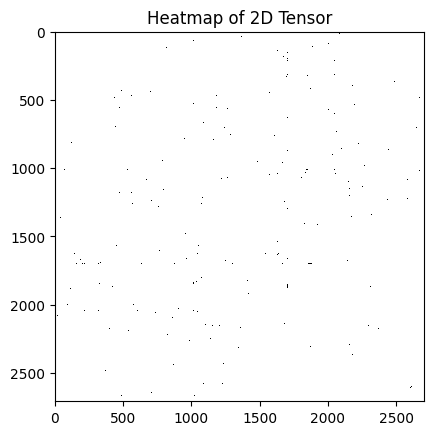

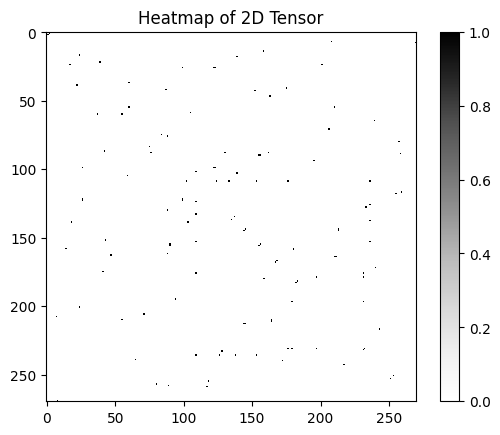

In [313]:
import matplotlib.pyplot as plt
adj_mat_inp = pyg.utils.to_dense_adj(graphs['input'].edge_index, 
                                     max_num_nodes=graphs['input'].x.size(0)).squeeze().numpy()
adj_mat_out = pyg.utils.to_dense_adj(graphs['output'].edge_index, 
                                     max_num_nodes=graphs['input'].x.size(0)).squeeze().numpy()
# Plot the heatmap
plt.imshow(adj_mat_inp, cmap='Greys', interpolation='nearest')
plt.title("Heatmap of 2D Tensor")
plt.show()
plt.imshow(adj_mat_out[:split, :split], cmap='Greys', interpolation='nearest')
plt.colorbar()  # Add a colorbar to a plot
plt.title("Heatmap of 2D Tensor")
plt.show()

In [283]:

# Convert the tensor to a NumPy array
# Plot the heatmap


In [316]:
# use the trained model to generate the missing part
baseline_net(graphs['input'])

tensor([[0.0357, 0.0193, 0.0194,  ..., 0.0133, 0.0193, 0.0174],
        [0.0193, 0.0336, 0.0331,  ..., 0.0277, 0.0336, 0.0307],
        [0.0194, 0.0331, 0.0327,  ..., 0.0272, 0.0331, 0.0303],
        ...,
        [0.0133, 0.0277, 0.0272,  ..., 0.0324, 0.0277, 0.0252],
        [0.0193, 0.0336, 0.0331,  ..., 0.0277, 0.0336, 0.0307],
        [0.0174, 0.0307, 0.0303,  ..., 0.0252, 0.0307, 0.0289]],
       grad_fn=<MmBackward0>)

In [285]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

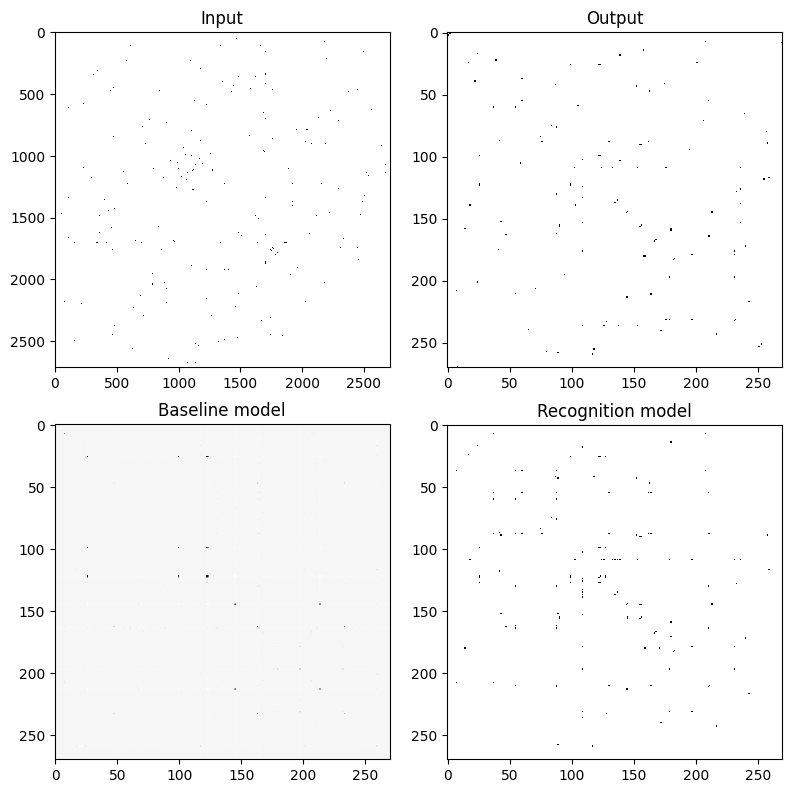

In [319]:
dim = graphs['input'].x.size(0)
adj_mat_inp = pyg.utils.to_dense_adj(graphs['input'].edge_index,
                                     max_num_nodes=graphs['input'].x.size(0)).squeeze().numpy()
adj_mat_out = pyg.utils.to_dense_adj(graphs['output'].edge_index,
                                     max_num_nodes=graphs['input'].x.size(0)).squeeze().numpy()
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
threshold = 0.8
split = int(dim * 0.1)

fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.subplot(221)
plt.imshow(adj_mat_inp, cmap='Greys', interpolation='nearest')
# plt.colorbar()  # Add a colorbar to a plot
plt.title("Input")

plt.subplot(222)
plt.imshow(adj_mat_out[:split, :split], cmap='Greys', interpolation='nearest')
# plt.colorbar()  # Add a colorbar to a plot
plt.title("Output")

plt.subplot(223)
adj_mat_np = baseline_net(graphs['input']).detach().numpy()[:split, :split]
# adj_mat_np[adj_mat_np < threshold] = 0
# adj_mat_np = np.random.binomial(1, adj_mat_np)
plt.imshow(adj_mat_np, cmap='Greys', interpolation='nearest')
# plt.colorbar()  # Add a colorbar to a plot
plt.title("Baseline model")

plt.subplot(224)
adj_mat_np = np.zeros((split, split))
for i in range(100):
    adj_mat_np += sigmoid(cgvae_net.generate().detach().numpy())[:split, :split]
adj_mat_np /= 100
adj_mat_np[adj_mat_np < threshold] = 0
adj_mat_np[adj_mat_np >= threshold] = 1
np.fill_diagonal(adj_mat_np, 0)
plt.imshow(adj_mat_np, cmap='Greys', interpolation='nearest')
# plt.colorbar()  # Add a colorbar to a plot
plt.title("Recognition model")

# also try unconditional generation


plt.show()



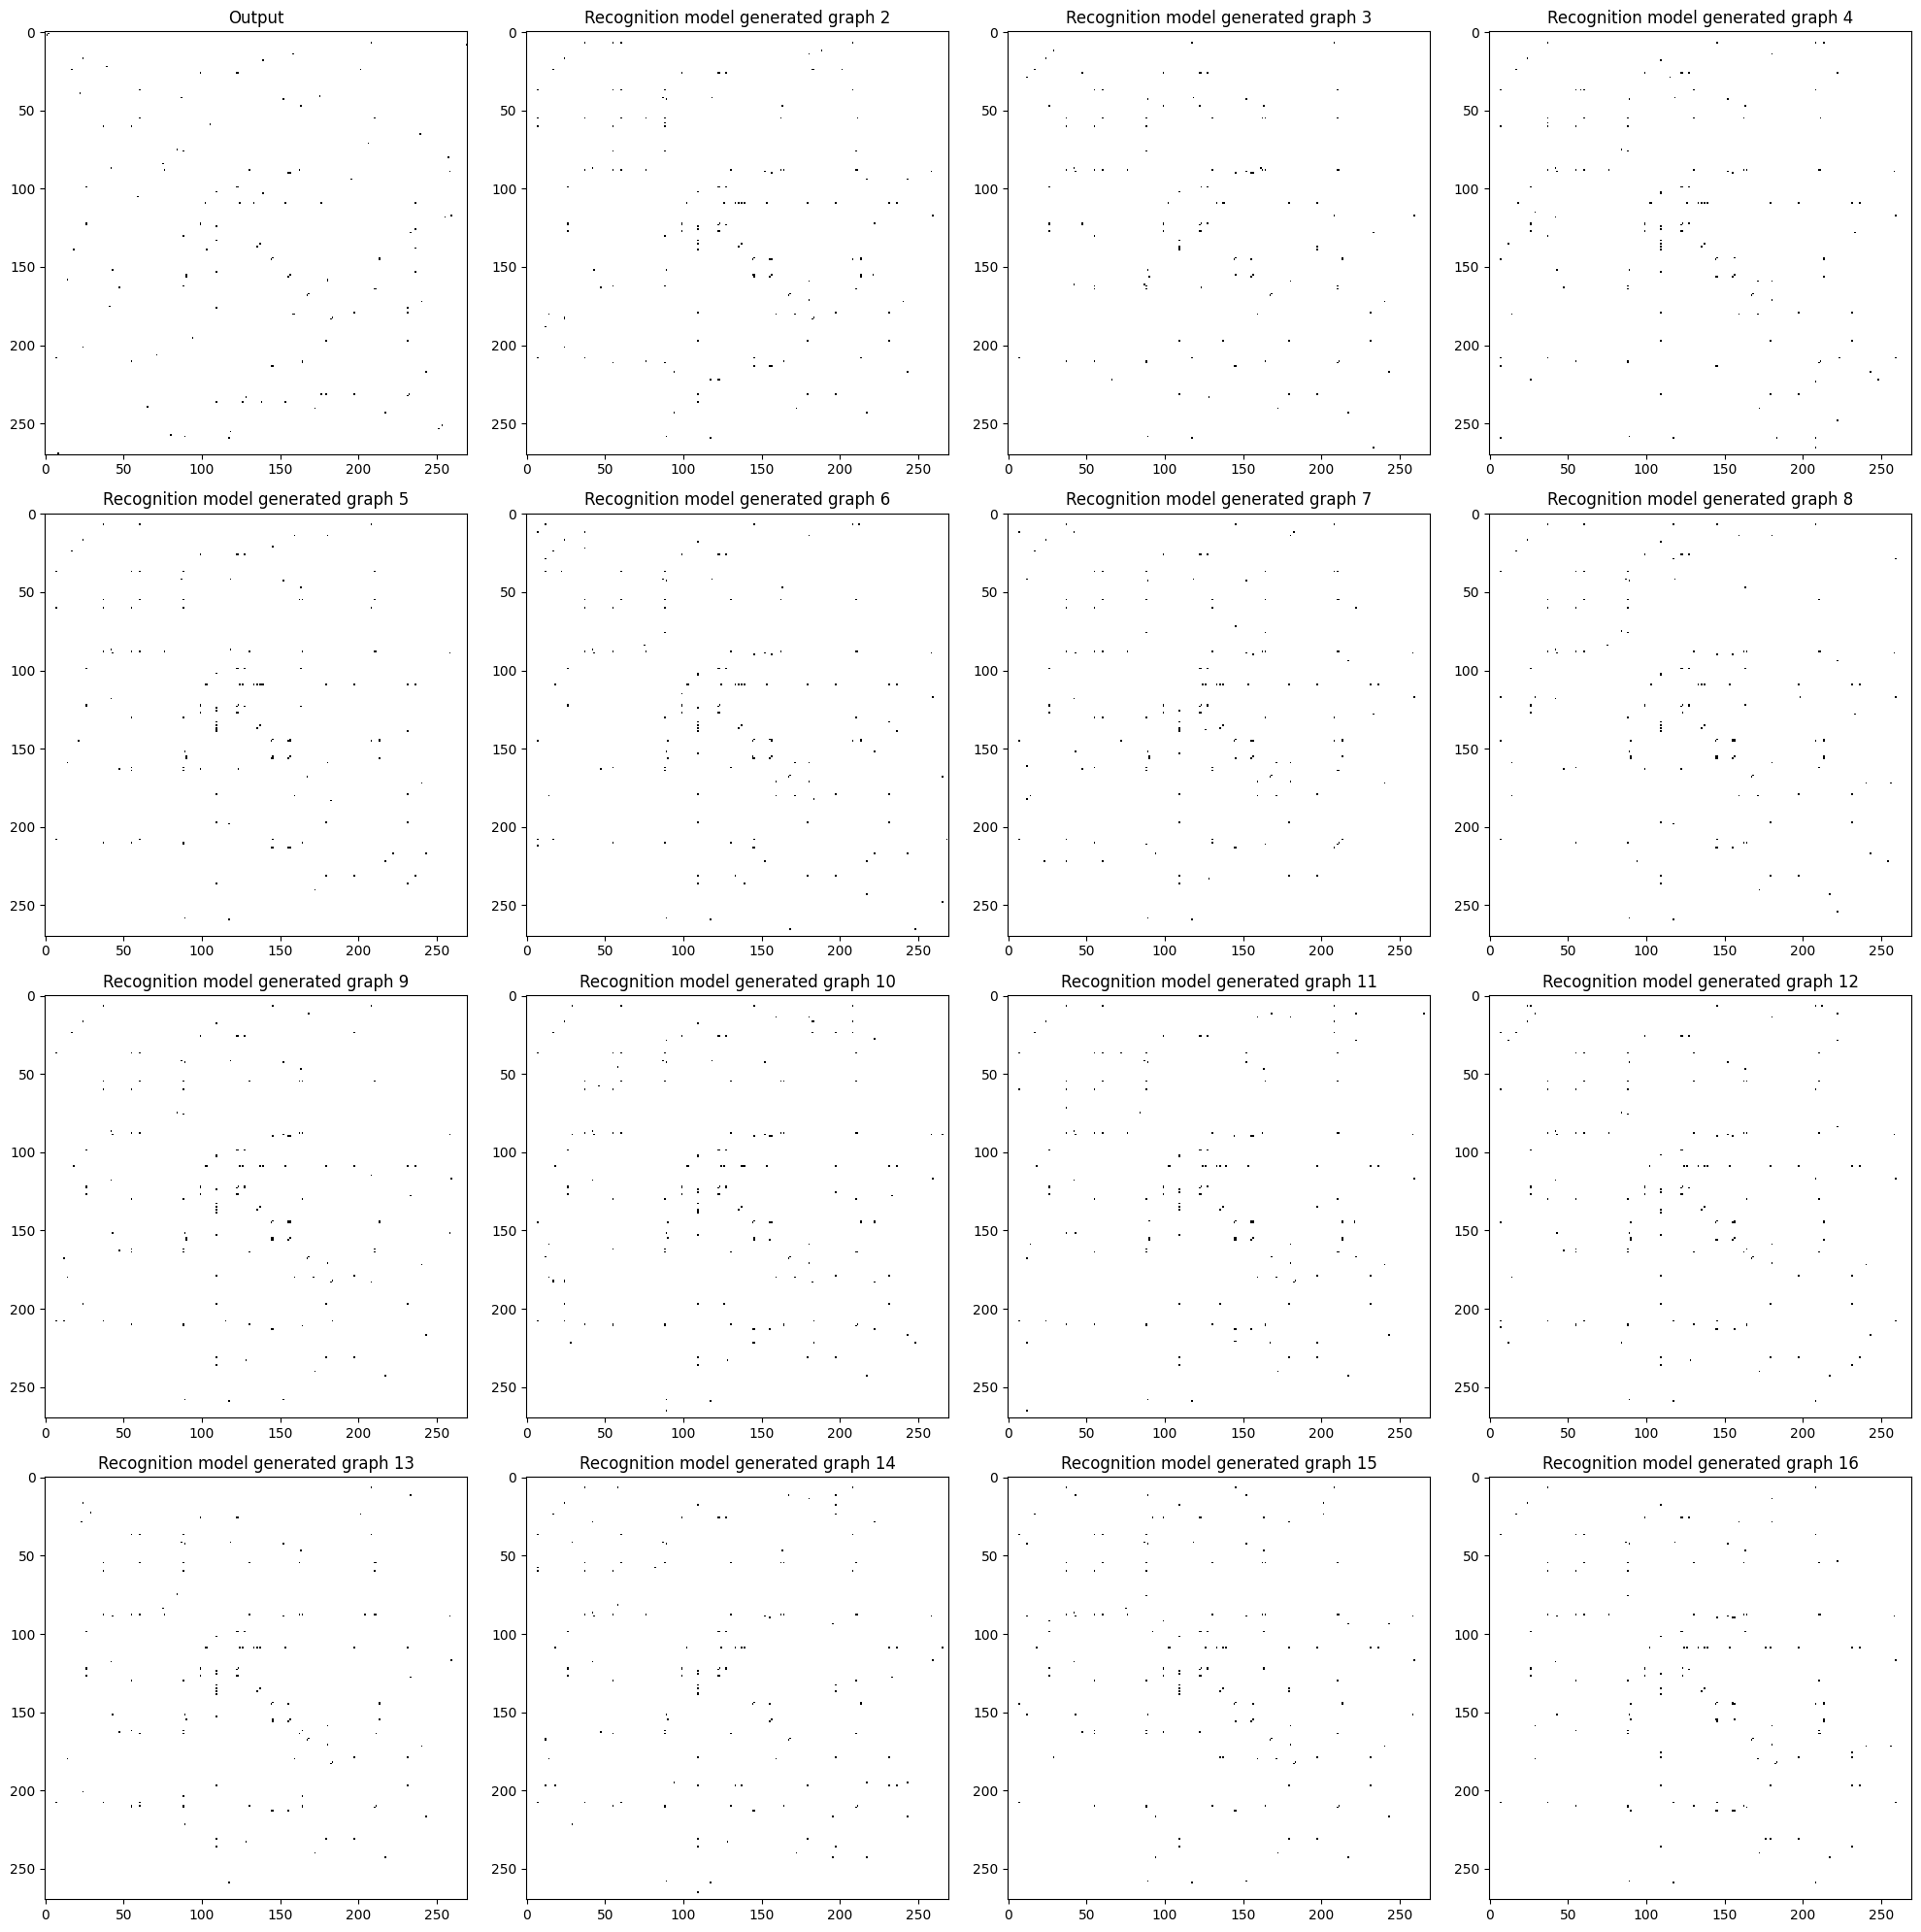

In [304]:
threshold = 0.8

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))  # Create a grid of 2 rows and 5 columns for the subplots
axes = axes.flatten()  # Flatten the axes array for easy iteration

ax = axes[0]
ax.imshow(adj_mat_out[:split, :split], cmap='Greys', interpolation='nearest')
# plt.colorbar()  # Add a colorbar to a plot
ax.set_title("Output")

for i in range(1, 16):
    adj_mat_np = sigmoid(cgvae_net.generate().detach().numpy())[:split, :split]
    adj_mat_np[adj_mat_np < threshold] = 0
    adj_mat_np = np.random.binomial(1, adj_mat_np)
    np.fill_diagonal(adj_mat_np, 0)
    ax = axes[i]  # Select the i-th subplot
    ax.imshow(adj_mat_np, cmap='Greys', interpolation='nearest')  # Plot the matrix in the i-th subplot
    ax.set_title(f"Recognition model generated graph {i+1}")  # Set the title for the i-th subplot

plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()  # Display the plots

In [352]:
from torch_geometric.nn import GCNConv
from torch_geometric.transforms import ToUndirected
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from datetime import time
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from torch_geometric.nn import VGAE
# Unconditional generation
class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv_mu = GCNConv(2 * out_channels, out_channels)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


class VGAEWithGenerate(VGAE):
    def __init__(self, encoder):
        super().__init__(encoder)
        self.encoder = encoder
        
    def generate(self):
        z = self.reparametrize(self.__mu__, self.__logstd__)
        return self.decoder.forward_all(z)

vgae_model = VGAEWithGenerate(VariationalGCNEncoder(1433, 50))
model = vgae_model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


train_data = Planetoid(root='../data', name='Cora', pre_transform=ToUndirected())[0]
train_data.pos_edge_label_index = train_data.edge_index
train_data.neg_edge_label_index = pyg.utils.negative_sampling(
    train_data.edge_index, num_nodes=train_data.num_nodes)

# train the model
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)
    loss = model.recon_loss(z, train_data.pos_edge_label_index)
    loss = loss + (1 / train_data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)

times = []
for epoch in range(1, 100 + 1):
    # start = time.time()
    loss = train()
    # auc, ap = test(test_data)
    # print(f'Epoch: {epoch:03d}, AUC: {auc:.4f}, AP: {ap:.4f}')
    # times.append(time.time() - start)
# print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")


tensor([[0.9477, 0.4808, 0.6281,  ..., 0.4248, 0.8445, 0.8468],
        [0.4808, 0.9730, 0.9169,  ..., 0.5751, 0.5540, 0.5503],
        [0.6281, 0.9169, 0.9526,  ..., 0.4536, 0.8351, 0.8144],
        ...,
        [0.4248, 0.5751, 0.4536,  ..., 0.9590, 0.5656, 0.5790],
        [0.8445, 0.5540, 0.8351,  ..., 0.5656, 0.9733, 0.9547],
        [0.8468, 0.5503, 0.8144,  ..., 0.5790, 0.9547, 0.9617]],
       grad_fn=<SigmoidBackward0>)

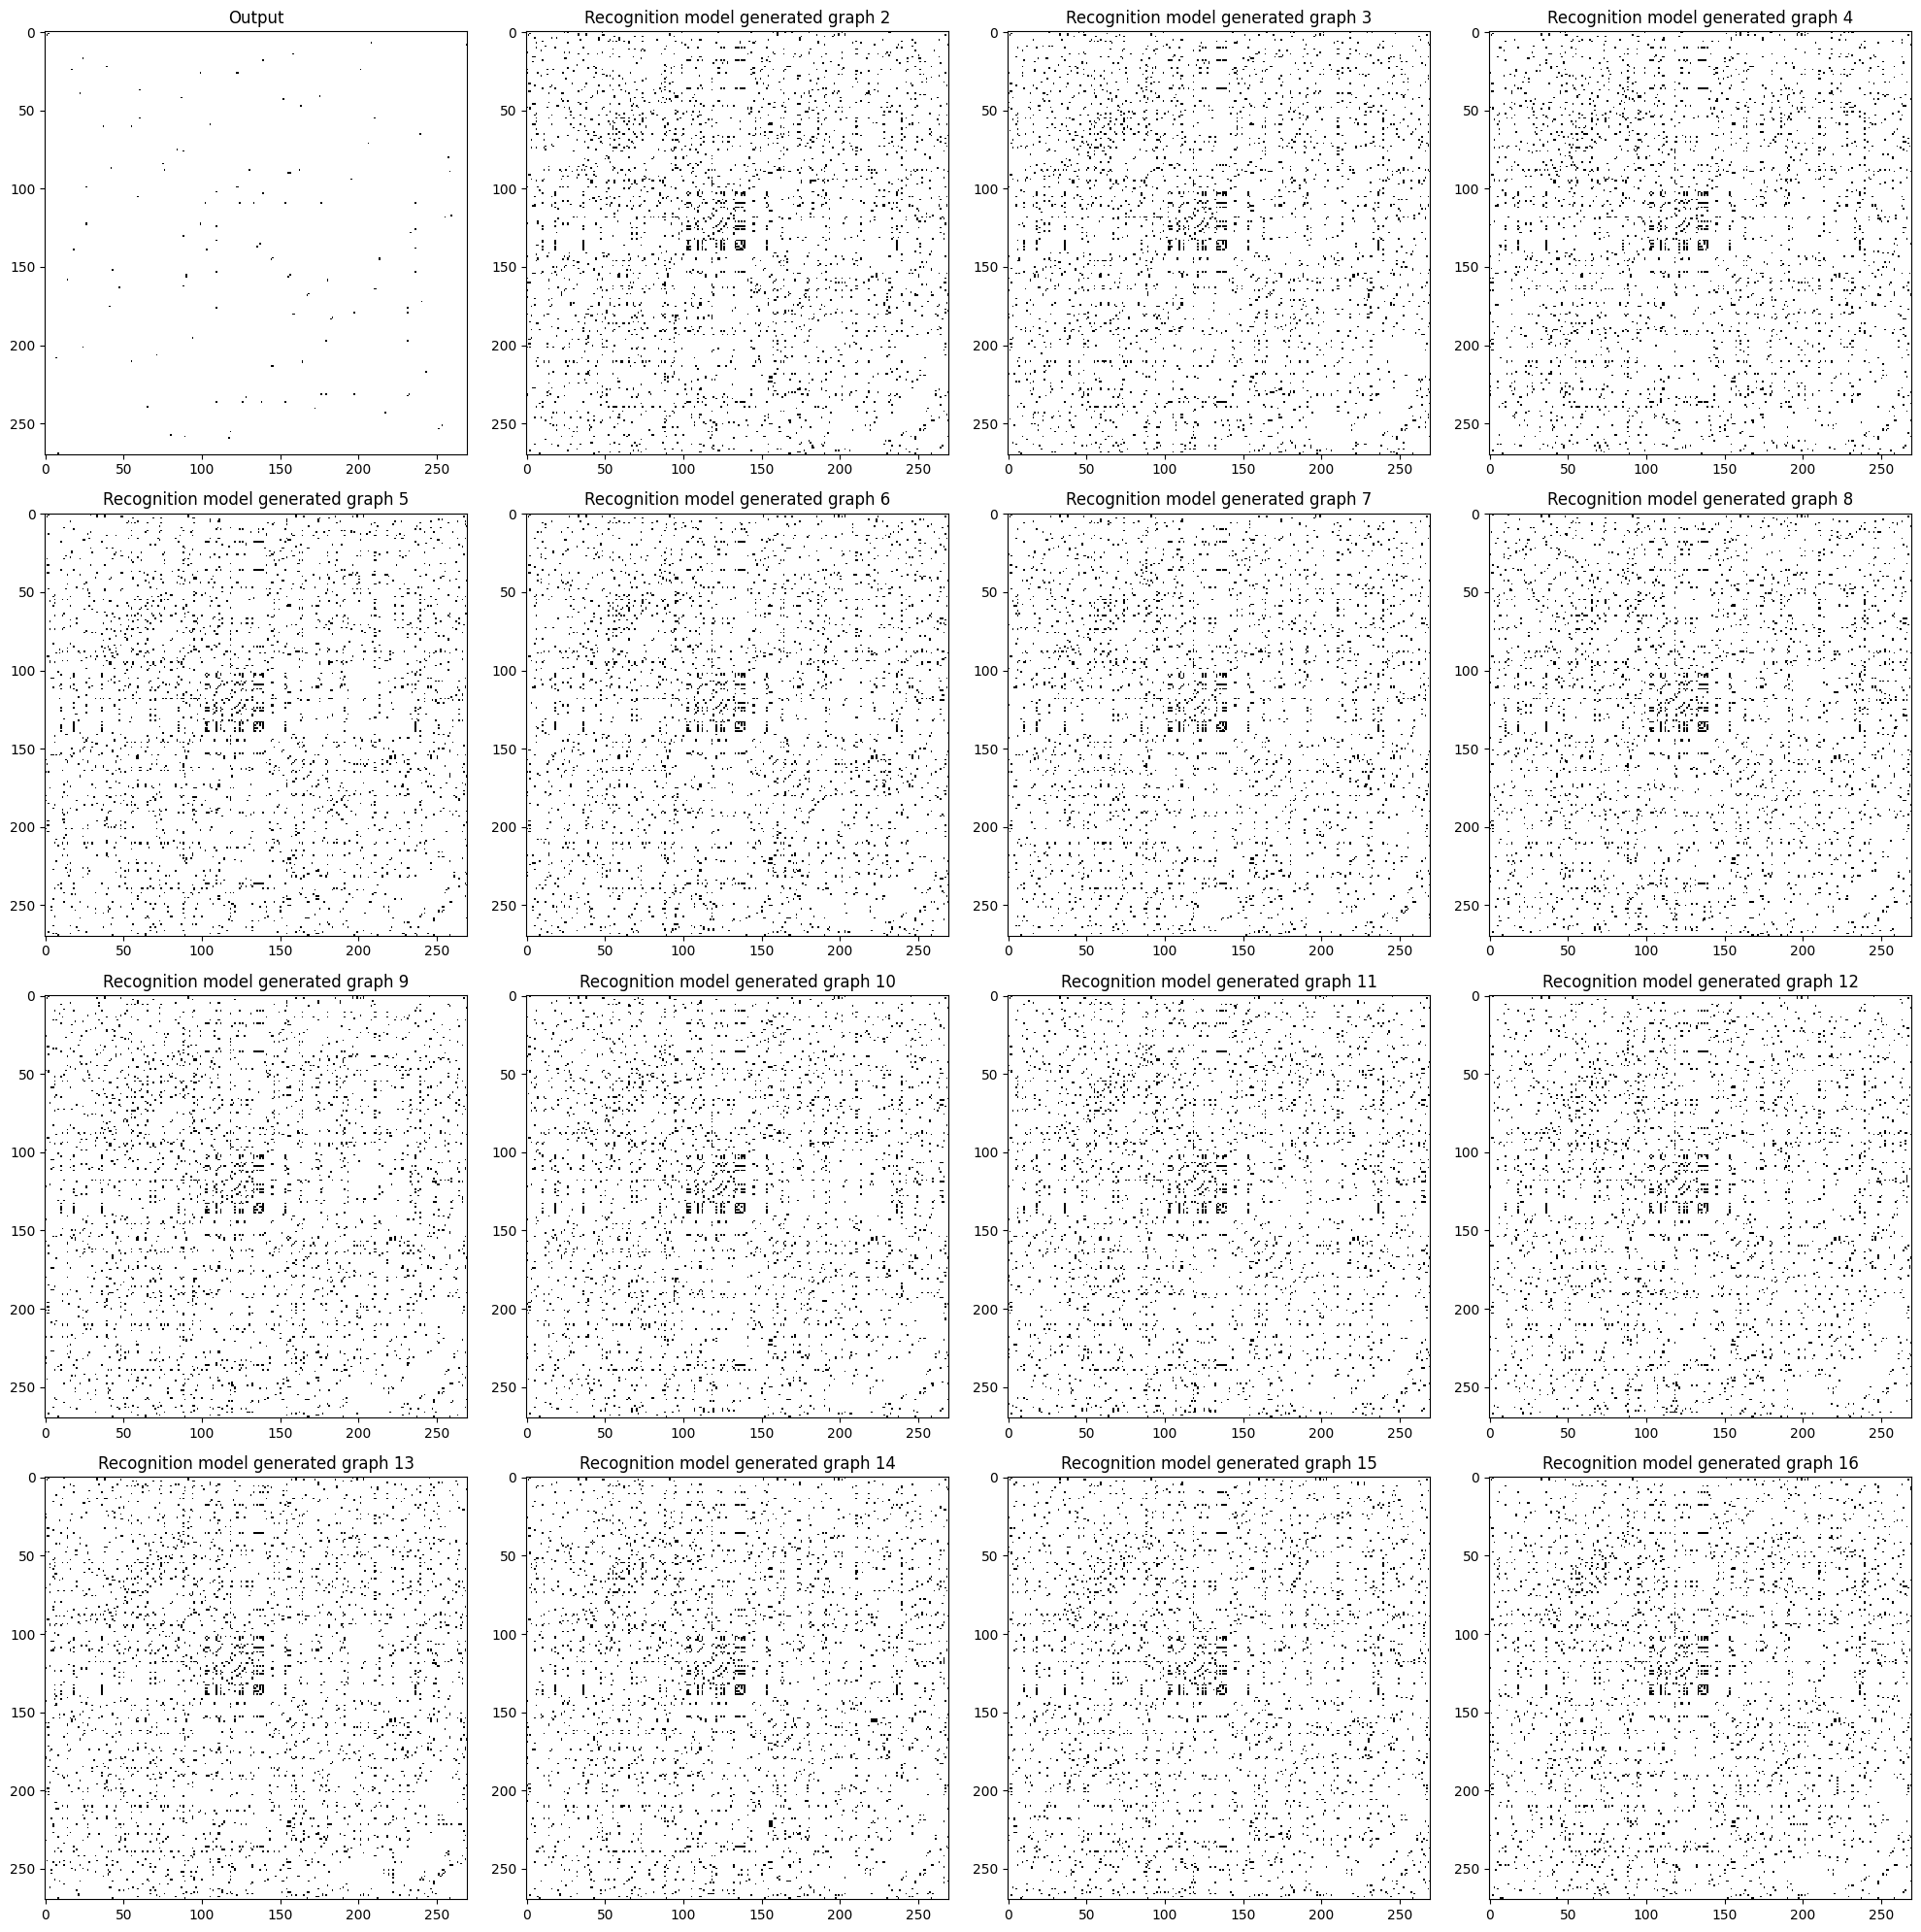

In [354]:
threshold = 0.8

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))  # Create a grid of 2 rows and 5 columns for the subplots
axes = axes.flatten()  # Flatten the axes array for easy iteration

ax = axes[0]
ax.imshow(adj_mat_out[:split, :split], cmap='Greys', interpolation='nearest')
# plt.colorbar()  # Add a colorbar to a plot
ax.set_title("Output")

for i in range(1, 16):
    adj_mat_np = vgae_model.generate().detach().numpy()[:split, :split]
    adj_mat_np[adj_mat_np < threshold] = 0
    adj_mat_np = np.random.binomial(1, adj_mat_np)
    np.fill_diagonal(adj_mat_np, 0)
    ax = axes[i]  # Select the i-th subplot
    ax.imshow(adj_mat_np, cmap='Greys', interpolation='nearest')  # Plot the matrix in the i-th subplot
    ax.set_title(f"Recognition model generated graph {i+1}")  # Set the title for the i-th subplot

plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()  # Display the plots